## Exercise 2
Eetu Knutars, MVDIA, January 21st

### Implementing the CNN on PyTorch

Importing libraries

In [1]:
import numpy as np
from keras.datasets import cifar100,mnist
from keras.utils import normalize
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Loading and preprocessing data

In [13]:
(XTrain, yTrain), (XTest, yTest) = mnist.load_data()

# Using some of the train set as validation set
XVali = XTrain[55000:60000]
yVali = yTrain[55000:60000]

XTrain = XTrain[0:55000]
yTrain = yTrain[0:55000]

# Reshaping image dimensions
XTrain = XTrain.reshape(XTrain.shape[0], 28, 28)
XTest = XTest.reshape(XTest.shape[0], 28, 28)
XVali = XVali.reshape(XVali.shape[0], 28, 28)
# Normalization
XTrain = normalize(XTrain, axis=1)
XTest = normalize(XTest, axis=1)
XVali = normalize(XVali, axis=1)

# Creating tensors
X_train_tensor = torch.tensor(XTrain)
y_train_tensor = torch.tensor(yTrain)
X_test_tensor = torch.tensor(XTest)
y_test_tensor = torch.tensor(yTest)
X_vali_tensor = torch.tensor(XVali)
y_vali_tensor = torch.tensor(yVali)

train_batch_size = 64
test_batch_size = 64
vali_batch_size = 64

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
vali_dataset = TensorDataset(X_vali_tensor, y_vali_tensor)
vali_loader = DataLoader(vali_dataset, batch_size=vali_batch_size, shuffle=False)

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.sigmoid(self.conv1(x))
        x = self.pool(x)
        x = torch.sigmoid(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)  # Apply softmax activation
        return x

# Instantiate the model
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

Epoch 1/30, Train Loss: 2.3016, Validation Loss: 2.3017
Epoch 2/30, Train Loss: 2.2801, Validation Loss: 2.1647
Epoch 3/30, Train Loss: 1.9570, Validation Loss: 1.8074
Epoch 4/30, Train Loss: 1.7854, Validation Loss: 1.7368
Epoch 5/30, Train Loss: 1.7188, Validation Loss: 1.6611
Epoch 6/30, Train Loss: 1.6689, Validation Loss: 1.6366
Epoch 7/30, Train Loss: 1.6503, Validation Loss: 1.6240
Epoch 8/30, Train Loss: 1.6400, Validation Loss: 1.6170
Epoch 9/30, Train Loss: 1.6327, Validation Loss: 1.6113
Epoch 10/30, Train Loss: 1.6235, Validation Loss: 1.5725
Epoch 11/30, Train Loss: 1.5773, Validation Loss: 1.5424
Epoch 12/30, Train Loss: 1.5617, Validation Loss: 1.5335
Epoch 13/30, Train Loss: 1.5536, Validation Loss: 1.5286
Epoch 14/30, Train Loss: 1.5480, Validation Loss: 1.5245
Epoch 15/30, Train Loss: 1.5431, Validation Loss: 1.5211
Epoch 16/30, Train Loss: 1.5389, Validation Loss: 1.5189
Epoch 17/30, Train Loss: 1.5356, Validation Loss: 1.5157
Epoch 18/30, Train Loss: 1.5325, Validat

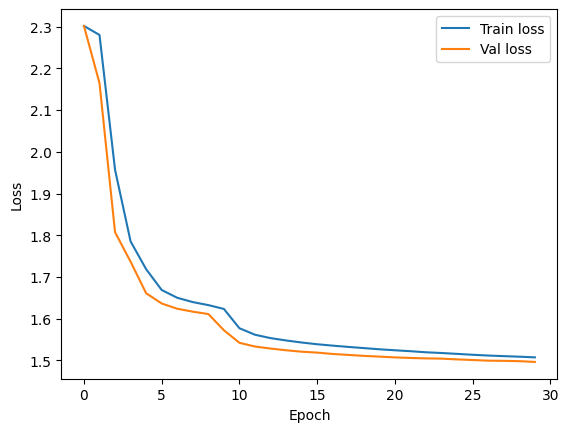

In [23]:
num_epochs = 30
best_val_loss = np.inf

val_losses = []
train_losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()

    # Epoch validation loss
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        for val_inputs, val_labels in vali_loader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
        val_running_loss /= len(vali_loader)

    val_losses.append(val_running_loss)
    train_losses.append(running_loss / len(train_loader))
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Stop training if validation loss has not decreased for 10 epochs
    if epoch > 10 and val_losses[-1] >= val_losses[-10]:
        break

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_running_loss:.4f}')

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Testing
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 96.36%


### Task 1
Play with a defined Convolutional Neural Network (CNN) on MNIST dataset which
available at google colab. Visualize the feature maps generated by the initial three layers:
- Conv2D
- AvgPooling2D
- Conv2D

Include an analysis of feature maps from various layers in your report. (Note: You can either
create a new Jupyter notebook on Google Colab or utilize your local computer. Other deep
learning frameworks (e.g., PyTorch) are also acceptable.) (1p)

In [34]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device)
        outputs_conv1 = model.conv1(inputs.view(-1, 1, 28, 28))
        outputs_pool = model.pool(outputs_conv1)
        outputs_conv2 = model.conv2(outputs_pool)
        break
conv1_output = outputs_conv1.cpu().numpy()
conv1_output = conv1_output[41,:,:,:]
conv2_output = outputs_conv2.cpu().numpy()
conv2_output = conv2_output[41,:,:,:]
pool_output = outputs_pool.cpu().numpy()
pool_output = pool_output[41,:,:,:]

Feature maps of the first Conv2D layer
- This layer applies a 2D convolution using a 5x5 kernel, and adds padding of size 2 to the image so the resulting image shape is 28x28, same as the input image
- The layer takes the one input channel and outputs 6 channels

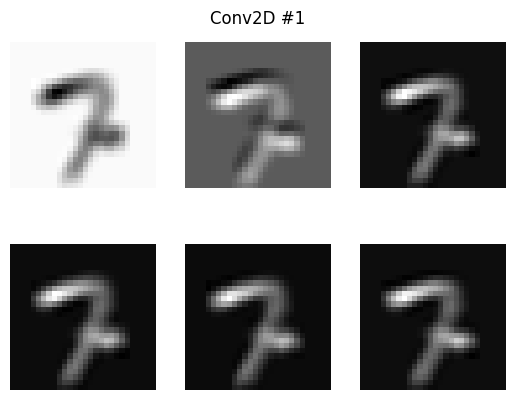

In [37]:
plt.figure()
plt.title('Conv2D #1')
plt.axis('off')
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(conv1_output[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

Feature maps of the AvgPool2D layer
- This layer applies an average pool with 2x2 kernels and stride of 2. This results a 14x14 sized image, so total image size is reduced to 1/4

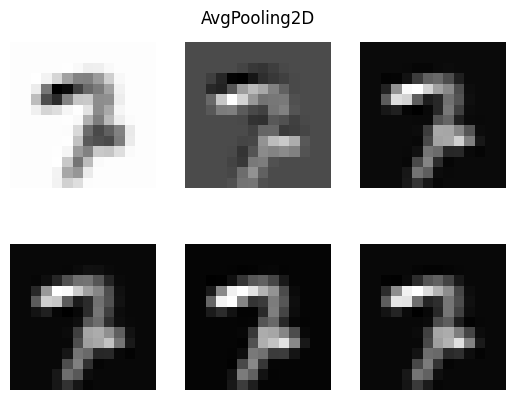

In [38]:
plt.figure()
plt.title('AvgPooling2D')
plt.axis('off')
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(pool_output[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

Feature maps of the seconds Conv2D layer
- This is the second convolutional layer, using a 5x5 kernel with no padding, so the result is 10x10 image.
- The layer takes 6 channels in and outputs 16 channels

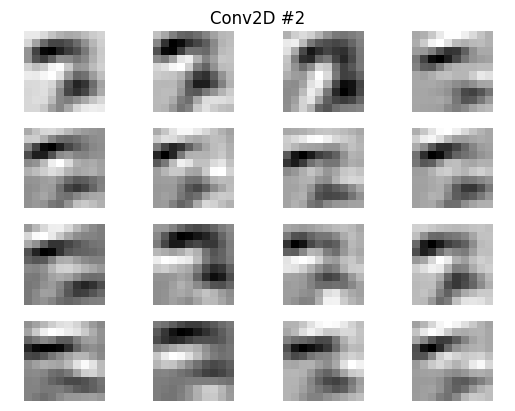

In [39]:
plt.figure()
plt.title('Conv2D #2')
plt.axis('off')
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(conv2_output[i, :, :], cmap='gray')
    plt.axis('off')
plt.show()

### Task 2
Capture images of your own handwriting, ensuring to include at least three different digits.
Subsequently, evaluate these images using the trained neural network. Include both the
captured images and the corresponding test results in your report. (1 p)

I drew all nine different digits once and created 28x28 grayscaled images of them. The code below classifies the digits using the pre-trained model. Digits are then visualized and the predicted value is shown above the images.

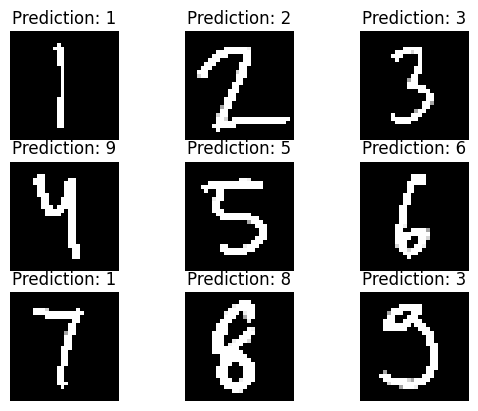

In [137]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()

plt.figure()
for i in range(1,10):
    img = plt.imread(f"hand_writing_{i}.png")[:,:,0]
    img_tensor = torch.tensor(img).view(1, 28, 28).to(device).float()
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)
    plt.subplot(3, 3, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Prediction: {predicted.item()}')

### Task 3
Experiment with adjusting hyper-parameters, such as learning rate, epoch, and the number of
feature maps. Observe the changes in the outcomes and provide an analysis in your report. (1
p)


Learning rate 
- For training this model I noticed learning rate ~0.001 was pretty optimal.
- Too big learning rate changed the weights too much, so the training loss didn't improve.
- Smaller learning rate didn't change the weights enough, again not improving the training loss.
- Scheduler could be used during training, since it adjusts the learning rate on the go.

Epoch number
- Too few epoch results the training loss not converging, and hence the test accuracy is not as good as it could be.
- Having too many epochs does no harm if using validation data, since the model will just stop improving. In this case its wise to stop training after validation loss has not improved in *N* epochs.
- If no validation data is used, the model might overfit to the training data.

Number of feature maps
- Increasing the amount of feature maps naturally increases the amount of trained parameters in the model, making the training process computationally more expensive
- Test accuracy can be improved a bit by increasing model complexity, however if the improvement is marginal then the simpler model may be a better option (Occam's razor)

### Task 4
Modify the provided network and draw a diagram of structure of modified network. Train
this modified network on the CIFAR100 dataset, aiming to enhance the accuracy on the test
set to at least 40%. (2p)

In [2]:
# load data
(XTrain, yTrain), (XTest, yTest) = cifar100.load_data(label_mode="coarse")

# Using some of the train data as validation set
XVali = XTrain[45000:50000]
yVali = yTrain[45000:50000]

XTrain = XTrain[0:45000]
yTrain = yTrain[0:45000]

# Squashing the labels
yTrain = yTrain.squeeze()
yTest = yTest.squeeze()
yVali = yVali.squeeze()

# Creating tensors
X_train_tensor = torch.tensor(XTrain)
y_train_tensor = torch.tensor(yTrain)
X_test_tensor = torch.tensor(XTest)
y_test_tensor = torch.tensor(yTest)
X_vali_tensor = torch.tensor(XVali)
y_vali_tensor = torch.tensor(yVali)

train_batch_size = 64
test_batch_size = 64
vali_batch_size = 64

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
vali_dataset = TensorDataset(X_vali_tensor, y_vali_tensor)
vali_loader = DataLoader(vali_dataset, batch_size=vali_batch_size, shuffle=False)

Defining the model architecture. In this model I use four convolutional layers, batch normalization after every convolution layer and max pooling after every two convolutional layers. At the end I have two linear (dense) layers and one dropout layer with 50% dropout. I use ReLU activation.

I tried different learning rates, and settled to 0.0005. I use a scheduler that adjusts the learning rate during training.

In [4]:
class CNN_CIFAR(nn.Module):
    def __init__(self):
        super(CNN_CIFAR, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) 
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 20)  # 20 classes

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(-1, 3, 32, 32) # reshape the input
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNN_CIFAR()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNN_CIFAR(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn_fc1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Training the model. I do 30 epochs max and end the training after validation loss stops improving

Epoch 1/30, Train Loss: 2.3832, Validation Loss: 2.1795
Epoch 2/30, Train Loss: 2.0612, Validation Loss: 2.0175
Epoch 3/30, Train Loss: 1.8948, Validation Loss: 2.0035
Epoch 4/30, Train Loss: 1.7249, Validation Loss: 1.9080
Epoch 5/30, Train Loss: 1.5088, Validation Loss: 1.9096
Epoch 6/30, Train Loss: 1.2541, Validation Loss: 2.0103
Epoch 7/30, Train Loss: 0.9541, Validation Loss: 2.0900
Epoch 8/30, Train Loss: 0.6665, Validation Loss: 2.2840
Epoch 9/30, Train Loss: 0.4555, Validation Loss: 2.5150
Epoch 10/30, Train Loss: 0.3379, Validation Loss: 2.6454
Epoch 11/30, Train Loss: 0.2570, Validation Loss: 2.8511


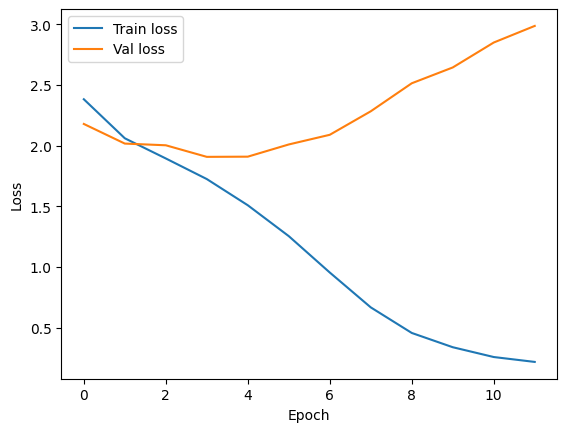

In [66]:
num_epochs = 30
best_val_loss = np.inf

val_losses = []
train_losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device).float(), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Track loss and accuracy
        running_loss += loss.item()

    # Epoch validation loss
    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        for val_inputs, val_labels in vali_loader:
            val_inputs, val_labels = val_inputs.to(device).float(), val_labels.to(device).long()
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
        val_running_loss /= len(vali_loader)

    val_losses.append(val_running_loss)
    train_losses.append(running_loss / len(train_loader))
    if val_running_loss < best_val_loss:
        best_val_loss = val_running_loss
        torch.save(model.state_dict(), 'best_model_cifer.pth')

    # Stop training if validation loss has not decreased for 10 epochs
    if epoch > 10 and val_losses[-1] >= val_losses[-10]:
        break

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Validation Loss: {val_running_loss:.4f}')

plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model evaluation and calculating test accuracy

In [ ]:

model.load_state_dict(torch.load('best_model_cifer.pth', weights_only=True))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 41.48%


Test accuracy of over 40% was achieved, not super good still but acceptable for 20 class case (random selection would have 5% accuracy)

Visualizing the model architecture with Graphviz 

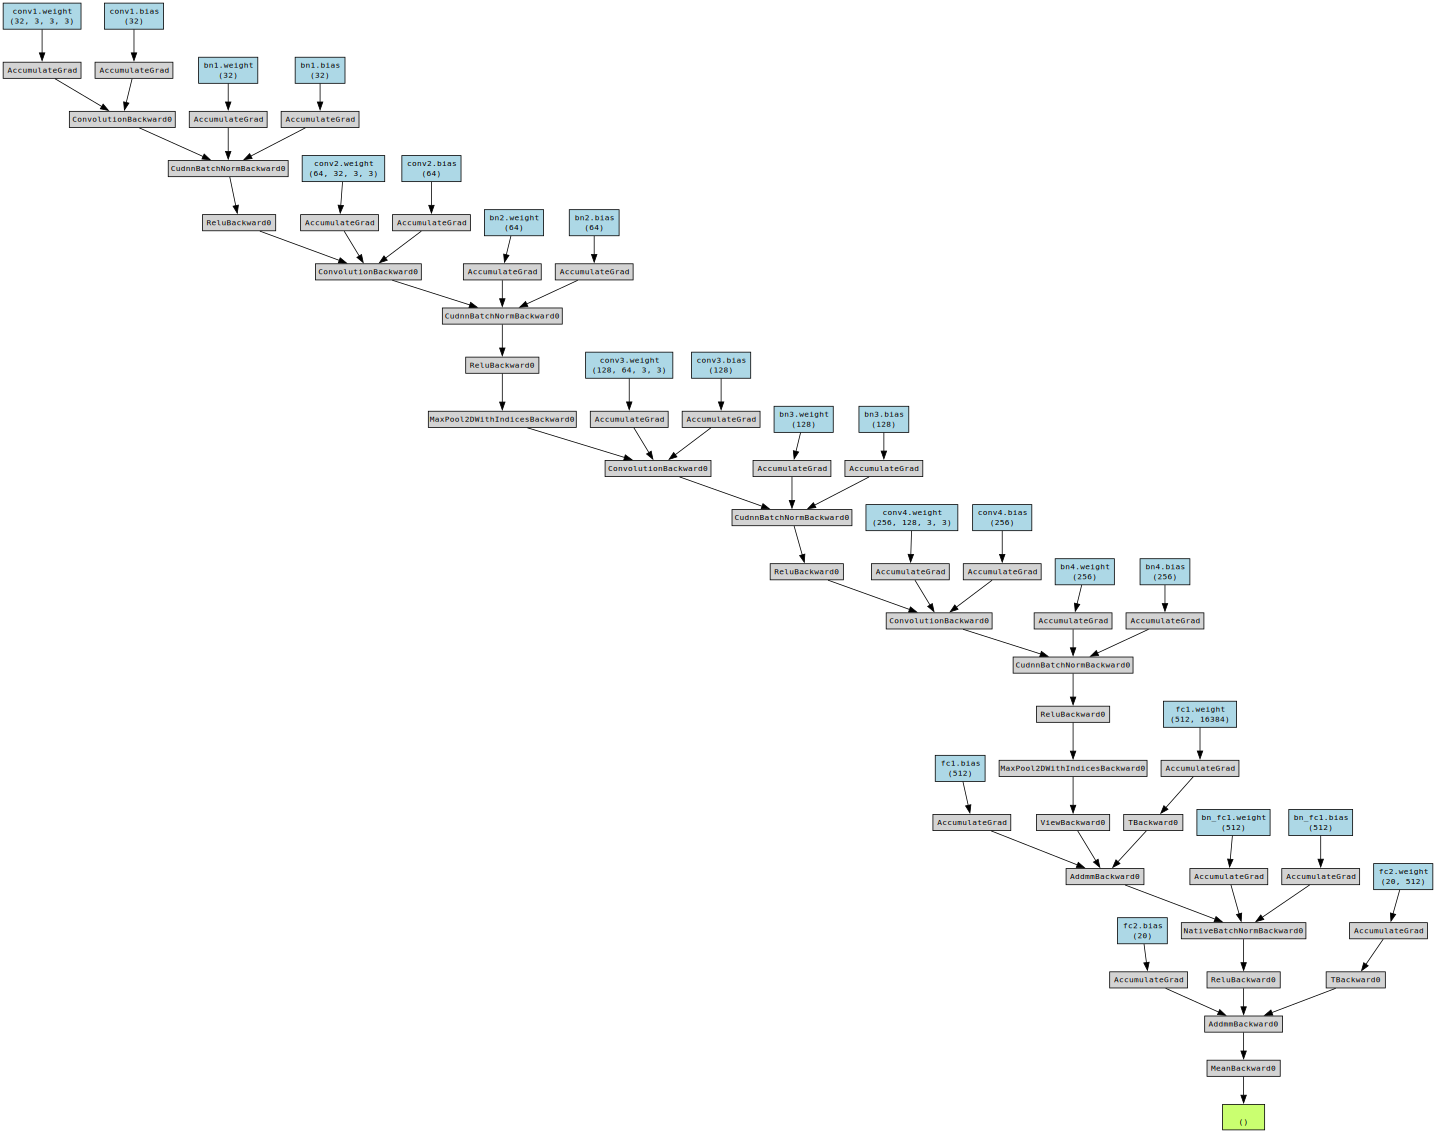

In [11]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'
from torchviz import make_dot

y = model(X_train_tensor[0].reshape(1,3,32,32).to(device).float())
make_dot(y.mean(), params=dict(model.named_parameters()))